# 0. Initialisation

In [ ]:
# INITIALISATION COMMUNE (BASE SEULEMENT)
# Cette cellule contient uniquement l'initialisation de base

from preprocess import ProductClassificationPipeline, PipelineConfig
from utils import generate_prediction_report, analyze_prediction_errors, plot_prediction_distribution
from data.processed_data.executer_pour_telecharger_donnees import telecharger_et_extraire_zip
import pandas as pd
import numpy as np
import os
import sys
import yaml

# Configuration des URLs et chemins
url = "https://drive.google.com/file/d/1guhuHp0dVRPWCtZ7570jEsTub6m2RrRF/view?usp=sharing"
fichier_zip = "Preprocessed_data.zip"
dossier_donnees_pretraitees = "data/processed_data"
fichier_donnees_pretraitees = "data/processed_data/y_train.npz"

def load_model_configs():
    """
    Charge les configurations des mod√®les depuis le YAML
    
    Returns:
        dict: Configurations des mod√®les avec leurs param√®tres
    """
    try:
        config_path = os.path.join('data', 'models', 'model_configs.yaml')
        with open(config_path, 'r', encoding='utf-8') as f:
            configs = yaml.safe_load(f)
        
        # V√©rification de la pr√©sence de tous les mod√®les attendus
        expected_models = {'xgboost', 'neural_net'}
        missing_models = expected_models - set(configs.keys())
        
        if missing_models:
            print(f"Attention : mod√®les manquants dans la configuration : {missing_models}")
            
        return configs
        
    except Exception as e:
        print(f"Erreur lors du chargement des configurations : {str(e)}")
        return {}

# Configuration du preprocessing
force_preprocess_image = False  # Mettre √† True pour forcer le preprocessing des images
force_preprocess_texte = False  # Mettre √† True pour forcer le preprocessing du texte

if not force_preprocess_image and not os.path.exists(fichier_donnees_pretraitees):        
    # T√©l√©charger et extraire les donn√©es pr√©trait√©es
    telecharger_et_extraire_zip(
        url=url,
        fichier_zip=fichier_zip,
        dossier_extraction=dossier_donnees_pretraitees
    )

# Configuration et cr√©ation du pipeline
print("1. Configuration du pipeline...")
config = PipelineConfig.from_yaml('config.yaml')
pipeline = ProductClassificationPipeline(config)

# Pr√©traitement des donn√©es (avec les bons param√®tres)
print("2. Pr√©paration des donn√©es de base...")
try:
    pipeline.prepare_data(
        force_preprocess_image=force_preprocess_image,
        force_preprocess_text=force_preprocess_texte
    )
    print("‚úì Donn√©es de base pr√©par√©es avec succ√®s")
except Exception as e:
    print(f"Erreur lors du pr√©traitement : {str(e)}")
    sys.exit(1)

# Chargement des configurations des mod√®les
print("3. Chargement des configurations des mod√®les...")
models_config = load_model_configs()

# Sauvegarde des indices pour les tests futurs
print("4. Sauvegarde des indices...")
indices_dict = pipeline.extract_and_save_indices()

# Cr√©ation des r√©pertoires n√©cessaires
os.makedirs('data/reports', exist_ok=True)
os.makedirs('data/explanations', exist_ok=True)
os.makedirs('data/rapports', exist_ok=True)
os.makedirs('data/erreurs', exist_ok=True)
os.makedirs('data/results', exist_ok=True)

print("\n=== ‚úì INITIALISATION COMMUNE TERMIN√âE ===")
print(f"Pipeline configur√© et donn√©es de base pr√©par√©es")
print(f"Configurations des mod√®les charg√©es: {list(models_config.keys())}")
print(f"Indices sauvegard√©s pour {len(indices_dict)} ensembles de donn√©es")
print(f"Force preprocess image: {force_preprocess_image}")
print(f"Force preprocess texte: {force_preprocess_texte}")

GPU disponible : Quadro M1200
CUDA Memory: 0.00GB / 0.00GB
1. Configuration du pipeline...
2. Pr√©paration des donn√©es de base...


2025-05-26 12:22:29,131 - classification_pipeline - INFO - Chargement des features pr√©-calcul√©es...
2025-05-26 12:22:30,198 - classification_pipeline - INFO - Chargement effectu√© avec succ√®s.


‚úì Donn√©es de base pr√©par√©es avec succ√®s
3. Chargement des configurations des mod√®les...
4. Sauvegarde des indices...


2025-05-26 12:22:31,232 - classification_pipeline - INFO - Indices sauvegard√©s dans data/indices
2025-05-26 12:22:31,233 - classification_pipeline - INFO - Distribution des indices:
2025-05-26 12:22:31,235 - classification_pipeline - INFO -   - Total: 84916
2025-05-26 12:22:31,237 - classification_pipeline - INFO -   - Test: 16984 (20.0%)
2025-05-26 12:22:31,238 - classification_pipeline - INFO -   - Train original: 67932 (80.0%)
2025-05-26 12:22:31,239 - classification_pipeline - INFO -   - Train balanced (unique): 44050 (51.9%)
2025-05-26 12:22:31,241 - classification_pipeline - INFO -   - Train balanced (total): 54000 (avec 9950 doublons (18.4%))
2025-05-26 12:22:31,244 - classification_pipeline - INFO -   - Ignor√©s: 23882 (28.1%)
2025-05-26 12:22:31,246 - classification_pipeline - INFO -   - V√©rification: 84916 = 84916 ‚úì



=== ‚úì INITIALISATION COMMUNE TERMIN√âE ===
Pipeline configur√© et donn√©es de base pr√©par√©es
Configurations des mod√®les charg√©es: ['xgboost', 'neural_net']
Indices sauvegard√©s pour 6 ensembles de donn√©es
Force preprocess image: False
Force preprocess texte: False


# 1. Gestion des mod√®les image (XGBoost et Neural Net)

In [ ]:
# V√©rification que l'initialisation a √©t√© faite
if 'pipeline' not in globals():
    print("ERREUR: Ex√©cutez d'abord la cellule d'initialisation (Cellule 0)")
    raise RuntimeError("Pipeline non initialis√©")

if __name__ == "__main__":
    # V√©rification que l'initialisation a √©t√© faite
    if 'pipeline' not in globals():
        print("ERREUR: Ex√©cutez d'abord la cellule d'initialisation (Cellule 0)")
        raise RuntimeError("Pipeline non initialis√©")

    # Chargement des mod√®les IMAGE uniquement
    print("1. Chargement des mod√®les image...")
    image_models_dict = {}

    for model_name in ['xgboost', 'neural_net']:
        model_dir = os.path.join(pipeline.config.model_path, model_name)
        if os.path.exists(model_dir):
            try:
                pipeline.load_model(model_name)
                image_models_dict[model_name] = pipeline.model
                print(f"‚úì Mod√®le {model_name} charg√©")
            except Exception as e:
                print(f"‚úó Erreur chargement {model_name}: {e}")
        else:
            print(f"‚úó Mod√®le {model_name} non trouv√© dans {model_dir}")

    if not image_models_dict:
        print("ERREUR: Aucun mod√®le image disponible")
        raise RuntimeError("Aucun mod√®le image charg√©")

    # Initialisation des r√©sultats
    all_results = {}
    models_to_test = {k: v for k, v in models_config.items() if k in image_models_dict.keys()}

    print(f"2. Mod√®les image √† tester: {list(models_to_test.keys())}")
    
    for model_name, params in models_to_test.items():
        print(f"\nTraitement  de {model_name}")
        # Recherche d'hyperparam√®tres (optionnel)
        recherche_hyperparametres = False
        if recherche_hyperparametres:
            print(f"\nRecherche des hyperparam√®tres pour {model_name}")            
            # Optimisation des hyperparam√®tres
            best_params = pipeline.optimize_hyperparameters(model_name)
            pipeline.save_hyperparameters(model_name, best_params)
            params.update(best_params)
    
        # Charger le mod√®le dans le pipeline (Nouveau, √† tester, remplace "pipeline.load_model(model_name)")
        pipeline.model = image_models_dict[model_name]
        
        # V√©rification et chargement des pr√©dictions
        if pipeline.predictions_exist(model_name):
            predictions, probabilities = pipeline.load_predictions(model_name)
            print(f"‚úì Pr√©dictions charg√©es pour {model_name}")
        else:
            print(f"G√©n√©ration des pr√©dictions pour {model_name}...")
            # G√©n√©rer les pr√©dictions sur les donn√©es image
            predictions, probabilities = pipeline.predict(pipeline.preprocessed_data['X_test_split'])
            
            # Sauvegarder les pr√©dictions
            pipeline.save_predictions(model_name, predictions, probabilities)
            print(f"‚úì Pr√©dictions g√©n√©r√©es et sauvegard√©es pour {model_name}")

            # Pr√©visions
            predictions, probabilities = pipeline.predict(pipeline.preprocessed_data['X_test_split'])
                        
            # Cr√©ation du DataFrame de sortie
            pipeline.save_predictions(model_name, predictions, probabilities)

        file_path_rapport = os.path.join('data', 'rapports', f'rapport_{model_name}.csv')
        file_path_erreurs = os.path.join('data', 'erreurs', f'erreurs_{model_name}.csv')
        if os.path.exists(file_path_rapport):
            print(f"Le rapport {model_name} existe.")
        if os.path.exists(file_path_erreurs):
            print(f"Le fichier erreurs {model_name} existe.")
            
        evalute = True #Forcer l'√©valuation (Maj des r√©sultats)
        plot_distribution  = False   #Pour ne pas afficher le graphe de distribution des pr√©dictions d√©j√† g√©n√©r√©
        if not os.path.exists(file_path_erreurs) or not os.path.exists(file_path_rapport) or evalute==True:    
            print(f"√âvaluation du mod√®le image {model_name}...")
            # Pr√©visions et √âvaluation
            all_results[model_name] = pipeline.evaluate()
            plot_distribution = True
            
            print(f"‚úì R√©sultats pour {model_name}:")
            # Affichage des m√©triques principales
            main_metrics = ['accuracy', 'weighted_f1', 'mean_confidence']
            for metric in main_metrics:
                if metric in all_results[model_name]:
                    print(f"  {metric}: {all_results[model_name][metric]:.4f}")

        # Cr√©ation du DataFrame de r√©sultats
        results_df = pd.DataFrame.from_dict(all_results, orient='index')
        
        # Cr√©ation du dossier results s'il n'existe pas
        results_dir = os.path.join('data', 'results')
        os.makedirs(results_dir, exist_ok=True)
        
        # Sauvegarde des r√©sultats en CSV
        results_path = os.path.join(results_dir, 'models_comparaison_results.csv')
        results_df.to_csv(results_path)
        
        # G√©n√©ration des rapports pour chaque mod√®le
        if not os.path.exists(file_path_rapport):
            rapport = generate_prediction_report(pipeline, predictions, probabilities)
            rapport.to_csv(file_path_rapport, index=False)
            # Visualisation
            if plot_distribution:
                plot_prediction_distribution(rapport, model_name)
        if not os.path.exists(file_path_erreurs):
            erreurs = analyze_prediction_errors(
                pipeline,
                predictions,
                pipeline.preprocessed_data['y_test_split']
            )
            erreurs.to_csv(file_path_erreurs, index=False)
            
    if all_results:
        # Cr√©ation du DataFrame de r√©sultats
        results_df = pd.DataFrame.from_dict(all_results, orient='index')
        
        # Sauvegarde des r√©sultats en CSV
        results_path = os.path.join('data', 'results', 'image_models_comparison_results.csv')
        results_df.to_csv(results_path)
        print(f"‚úì R√©sultats de comparaison IMAGE sauvegard√©s: {results_path}")

        # Affichage du r√©sum√© des r√©sultats IMAGE
        print("\n=== R√âSUM√â DES PERFORMANCES IMAGE ===")
        for model_name, metrics in all_results.items():
            print(f"\n{model_name.upper()}:")
            main_metrics = ['accuracy', 'weighted_f1', 'weighted_precision', 'weighted_recall', 'mean_confidence']
            for metric_name in main_metrics:
                if metric_name in metrics:
                    value = metrics[metric_name]
                    if isinstance(value, (int, float)):
                        print(f"  {metric_name}: {value:.4f}")

    print(f"\n=== ‚úì √âVALUATION MOD√àLES IMAGE TERMIN√âE ===")
    print(f"Mod√®les image √©valu√©s: {list(all_results.keys()) if all_results else 'Aucun (tous les rapports existaient d√©j√†)'}")
    print(f"Les mod√®les image sont pr√™ts pour l'analyse multimodale")

    # Rendre les mod√®les disponibles pour la cellule suivante
    print(f"Mod√®les image disponibles pour l'analyse multimodale: {list(image_models_dict.keys())}")

/home/elion/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU disponible : Quadro M1200
CUDA Memory: 0.00GB / 0.00GB


2025-05-15 10:56:38,587 - classification_pipeline - INFO - Chargement des features pr√©-calcul√©es...
2025-05-15 10:56:39,288 - classification_pipeline - INFO - Chargement effectu√© avec succ√®s.



Traitement  de xgboost


2025-05-15 10:56:39,630 - classification_pipeline - INFO - Mod√®le xgboost charg√© depuis ./data/models/xgboost
2025-05-15 10:56:39,684 - classification_pipeline - INFO - Pr√©diction avec mod√®le ML


Mod√®le xgboost charg√©
Type de X: <class 'numpy.ndarray'>
Shape de X: (16984, 2048)
Type des donn√©es: float32
Shape apr√®s conversion: (16984, 2048)


/home/elion/.pyenv/versions/3.10.12/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:56:39] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
2025-05-15 10:56:53,443 - classification_pipeline - INFO - Pr√©diction avec mod√®le ML


Le rapport xgboost existe.
Le fichier erreurs xgboost existe.
X_test shape: ()
Type de X: <class 'numpy.ndarray'>
Shape de X: (16984, 2048)
Type des donn√©es: float32
Shape apr√®s conversion: (16984, 2048)
y_test shape: (16984,)

R√©sultats pour le mod√®le xgboost:
 {'accuracy': 0.619, 'macro_precision': 0.595, 'macro_recall': 0.602, 'macro_f1': 0.59, 'weighted_precision': 0.638, 'weighted_recall': 0.619, 'weighted_f1': 0.622, 'precision': array([0.518, 0.519, 0.406, 0.629, 0.557, 0.891, 0.605, 0.478, 0.322,
       0.665, 0.724, 0.336, 0.471, 0.689, 0.814, 0.507, 0.519, 0.592,
       0.75 , 0.696, 0.556, 0.711, 0.421, 0.879, 0.357, 0.718, 0.737]), 'recall': array([0.618, 0.582, 0.467, 0.675, 0.691, 0.865, 0.32 , 0.293, 0.355,
       0.723, 0.702, 0.508, 0.532, 0.505, 0.807, 0.689, 0.541, 0.352,
       0.689, 0.613, 0.542, 0.676, 0.506, 0.711, 0.555, 0.848, 0.885]), 'f1': array([0.564, 0.548, 0.434, 0.651, 0.617, 0.877, 0.419, 0.363, 0.338,
       0.693, 0.713, 0.404, 0.5  , 0.583, 0.81

2025-05-15 10:57:08,253 - classification_pipeline - INFO - Mod√®le neural_net charg√© depuis ./data/models/neural_net


Mod√®le neural_net charg√©
Type de X: <class 'numpy.ndarray'>
Shape de X: (16984, 2048)
Type des donn√©es: float32
Shape apr√®s conversion: (16984, 2048)
Le rapport neural_net existe.
Le fichier erreurs neural_net existe.
X_test shape: ()
Type de X: <class 'numpy.ndarray'>
Shape de X: (16984, 2048)
Type des donn√©es: float32
Shape apr√®s conversion: (16984, 2048)
y_test shape: (16984,)

R√©sultats pour le mod√®le neural_net:
 {'accuracy': 0.624, 'macro_precision': 0.586, 'macro_recall': 0.613, 'macro_f1': 0.595, 'weighted_precision': 0.641, 'weighted_recall': 0.624, 'weighted_f1': 0.627, 'precision': array([0.517, 0.539, 0.426, 0.64 , 0.623, 0.87 , 0.477, 0.479, 0.329,
       0.702, 0.635, 0.425, 0.503, 0.646, 0.783, 0.55 , 0.521, 0.477,
       0.716, 0.716, 0.529, 0.742, 0.357, 0.911, 0.358, 0.723, 0.641]), 'recall': array([0.599, 0.518, 0.536, 0.717, 0.68 , 0.901, 0.399, 0.343, 0.336,
       0.724, 0.758, 0.516, 0.551, 0.537, 0.844, 0.714, 0.517, 0.442,
       0.711, 0.562, 0.585, 0.

# 2. Gestion du mod√®le texte SVM

In [ ]:
# √âVALUATION DU MOD√àLE TEXTE UNIQUEMENT
# Cette cellule traite uniquement le mod√®le de texte (SVM) en utilisant le pipeline

# V√©rification que l'initialisation a √©t√© faite
if 'pipeline' not in globals():
    print("ERREUR: Ex√©cutez d'abord la cellule d'initialisation (Cellule 0)")
    raise RuntimeError("Pipeline non initialis√©")

print("1. Chargement du mod√®le texte...")
text_model_loaded = pipeline.load_text_model('SVM')

print("2. Pr√©paration des donn√©es texte...")
X_text_test, y_text_test = pipeline.prepare_text_data()

# V√©rification des pr√©dictions existantes
model_name_text = 'SVM'
print("3. V√©rification des pr√©dictions existantes...")

if pipeline.text_predictions_exist(model_name_text):
    print(f"‚úì Chargement des pr√©dictions existantes pour {model_name_text}")
    predictions_text, probabilities_text = pipeline.load_text_predictions(model_name_text)
else:
    print(f"G√©n√©ration des pr√©dictions pour {model_name_text}...")
    predictions_text, probabilities_text = pipeline.predict_text()
    pipeline.save_text_predictions(predictions_text, probabilities_text, model_name_text)

print("4. √âvaluation du mod√®le texte...")
results_text, _, _ = pipeline.evaluate_text_model()

# Chemins des fichiers de rapport pour le texte
file_path_rapport_text = os.path.join('data', 'rapports', f'rapport_text_{model_name_text}.csv')
file_path_erreurs_text = os.path.join('data', 'erreurs', f'erreurs_text_{model_name_text}.csv')

rapport_text_exists = os.path.exists(file_path_rapport_text)
erreurs_text_exists = os.path.exists(file_path_erreurs_text)

if rapport_text_exists:
    print(f"‚úì Le rapport texte {model_name_text} existe.")
if erreurs_text_exists:
    print(f"‚úì Le fichier erreurs texte {model_name_text} existe.")

# G√©n√©ration des rapports sp√©cifiques au texte si n√©cessaire
evaluer_text = True  # Mettre √† False pour √©viter la r√©√©valuation

if not rapport_text_exists or evaluer_text:
    print(f"6. G√©n√©ration du rapport d√©taill√© pour le mod√®le texte...")
    
    # Cr√©er un rapport sp√©cifique au texte
    rapport_text_data = []
    
    for i, (pred, true_label) in enumerate(zip(predictions_text, y_text_test)):
        prob_max = np.max(probabilities_text[i])
        pred_class_name = pipeline.category_names.get(pred, f"Unknown_{pred}")
        true_class_name = pipeline.category_names.get(true_label, f"Unknown_{true_label}")
        
        rapport_text_data.append({
            'sample_id': i,
            'true_label': true_label,
            'true_class_name': true_class_name,
            'predicted_label': pred,
            'predicted_class_name': pred_class_name,
            'confidence': prob_max,
            'correct': pred == true_label,
            'text_sample': X_text_test[i][:100] + "..." if len(X_text_test[i]) > 100 else X_text_test[i]
        })
    
    rapport_text_df = pd.DataFrame(rapport_text_data)
    rapport_text_df.to_csv(file_path_rapport_text, index=False)
    print(f"‚úì Rapport texte sauvegard√©: {file_path_rapport_text}")

if not erreurs_text_exists or evaluer_text:
    print(f"7. Analyse des erreurs pour le mod√®le texte...")
    
    # Analyse des erreurs sp√©cifique au texte
    erreurs_text_data = []
    
    for i, (pred, true_label) in enumerate(zip(predictions_text, y_text_test)):
        if pred != true_label:  # Seulement les erreurs
            prob_max = np.max(probabilities_text[i])
            pred_class_name = pipeline.category_names.get(pred, f"Unknown_{pred}")
            true_class_name = pipeline.category_names.get(true_label, f"Unknown_{true_label}")
            
            erreurs_text_data.append({
                'sample_id': i,
                'true_label': true_label,
                'true_class_name': true_class_name,
                'predicted_label': pred,
                'predicted_class_name': pred_class_name,
                'confidence': prob_max,
                'error_type': 'low_confidence' if prob_max < 0.5 else 'high_confidence',
                'text_sample': X_text_test[i][:200] + "..." if len(X_text_test[i]) > 200 else X_text_test[i]
            })
    
    erreurs_text_df = pd.DataFrame(erreurs_text_data)
    erreurs_text_df.to_csv(file_path_erreurs_text, index=False)
    print(f"‚úì Analyse des erreurs texte sauvegard√©e: {file_path_erreurs_text}")

# Sauvegarde des r√©sultats du mod√®le texte
results_text_path = os.path.join('data', 'results', 'text_model_results.csv')
results_text_df = pd.DataFrame([results_text], index=[model_name_text])
results_text_df.to_csv(results_text_path)

print("\n=== R√âSUM√â DES PERFORMANCES TEXTE ===")
print(f"Mod√®le: {model_name_text}")
print(f"√âchantillons: {results_text['num_samples']}")
print(f"Accuracy: {results_text['accuracy']:.4f}")
print(f"F1-score pond√©r√©: {results_text['weighted_f1']:.4f}")
print(f"F1-score macro: {results_text['macro_f1']:.4f}")
print(f"Confiance moyenne: {results_text['mean_confidence']:.4f}")
print(f"√âchantillons faible confiance (<0.5): {results_text['low_confidence_samples']}")
print(f"√âchantillons haute confiance (>0.8): {results_text['high_confidence_samples']}")

print(f"\n=== ‚úì √âVALUATION MOD√àLE TEXTE TERMIN√âE ===")
print(f"Le mod√®le texte {model_name_text} est pr√™t pour l'analyse multimodale")
print(f"R√©sultats sauvegard√©s dans: {results_text_path}")

# Rendre le mod√®le texte disponible pour l'analyse multimodale
text_model_ready = True
text_model_name = model_name_text
print(f"Variables globales cr√©√©es: text_model_ready, text_model_name")

=== √âVALUATION DU MOD√àLE TEXTE ===
1. Extension du pipeline pour le texte...
2. Chargement du mod√®le texte...
‚úì Mod√®le texte SVM charg√©
3. Pr√©paration des donn√©es texte...
‚úì Donn√©es texte pr√©par√©es: 16984 √©chantillons
4. V√©rification des pr√©dictions existantes...
G√©n√©ration des pr√©dictions pour SVM...
‚úì Pr√©dictions texte sauvegard√©es pour SVM
5. √âvaluation du mod√®le texte...
6. G√©n√©ration du rapport d√©taill√© pour le mod√®le texte...
‚úì Rapport texte sauvegard√©: data/rapports/rapport_text_SVM.csv
7. Analyse des erreurs pour le mod√®le texte...
‚úì Analyse des erreurs texte sauvegard√©e: data/erreurs/erreurs_text_SVM.csv

=== R√âSUM√â DES PERFORMANCES TEXTE ===
Mod√®le: SVM
√âchantillons: 16984
Accuracy: 0.8116
F1-score pond√©r√©: 0.8161
F1-score macro: 0.8078
Confiance moyenne: 0.8217
√âchantillons faible confiance (<0.5): 2435
√âchantillons haute confiance (>0.8): 11592

=== ‚úì √âVALUATION MOD√àLE TEXTE TERMIN√âE ===
Le mod√®le texte SVM est pr√™t pour 

# 3. Fusion des mod√®les texte et image

In [4]:
# ====================  FUSION MULTIMODALE ====================
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score

print("=== ANALYSE MULTIMODALE ===")

# V√©rification des pr√©requis
if 'pipeline' not in globals():
    print("ERREUR: Ex√©cuter d'abord la cellule d'initialisation (Cellule 0)")
    raise RuntimeError("Pipeline non initialis√©")

print("1. Configuration des mod√®les multimodaux...")
# Charger tous les mod√®les n√©cessaires
models_to_test = {}

# Mod√®les image
for model_name in ['xgboost', 'neural_net']:
    model_dir = os.path.join(pipeline.config.model_path, model_name)
    if os.path.exists(model_dir):
        try:
            pipeline.load_model(model_name)
            models_to_test[model_name] = pipeline.model
            print(f"‚úì Mod√®le image {model_name} charg√©")
        except Exception as e:
            print(f"‚úó Erreur chargement {model_name}: {e}")

# Mod√®le texte
print("Chargement du mod√®le texte...")
try:
    text_model_loaded = pipeline.load_text_model('SVM')
    if text_model_loaded:
        models_to_test['text'] = pipeline.text_model
        print(f"‚úì Mod√®le texte SVM charg√©")
    else:
        print(f"‚ö† Mod√®le texte √† g√©n√©rer (Ex√©cuter Cellule 2)")
except Exception as e:
    print(f"‚úó Erreur chargement mod√®le texte: {e}")
    raise

if len(models_to_test) < 2:
    print("ERREUR: Pas assez de mod√®les disponibles pour l'analyse multimodale")
    raise RuntimeError("Mod√®les insuffisants")

print("2. Pr√©paration des donn√©es multimodales...")
# Pr√©paration des donn√©es texte - autonome
print("Pr√©paration des donn√©es texte...")
try:
    X_text_test, y_text_test = pipeline.prepare_text_data()
    print(f"‚úì Donn√©es texte pr√©par√©es: {len(X_text_test)} √©chantillons")
except Exception as e:
    print(f"‚úó Erreur pr√©paration donn√©es texte: {e}")
    raise

# Donn√©es image
X_image_test = pipeline.preprocessed_data['X_test_split']
if isinstance(X_image_test, dict):
    X_image_test = X_image_test['features']
elif X_image_test.shape == ():
    X_image_test = X_image_test.item()
    if isinstance(X_image_test, dict) and 'features' in X_image_test:
        X_image_test = X_image_test['features']

print(f"‚úì Donn√©es image extraites: {X_image_test.shape}")

# Alignement des dimensions
min_size = min(len(X_text_test), len(X_image_test), len(y_text_test))
X_text_test = X_text_test[:min_size]
X_image_test = X_image_test[:min_size]
y_test = y_text_test[:min_size]

print(f"Dimensions align√©es: {min_size} √©chantillons")

print("3. √âvaluation des combinaisons multimodales...")
# Dictionnaire pour stocker tous les r√©sultats
all_results = {}
fusion_strategies = ['mean', 'product', 'weighted', 'confidence_weighted']

# √âvaluation du texte seul
if 'text' in models_to_test:
    print("√âvaluation du mod√®le texte seul...")
    text_predictions, text_probabilities = pipeline.predict_text(X_text_test)
    
    # OPTIMISATION: Stocker pour r√©utilisation
    cached_text_predictions = text_predictions
    cached_text_probabilities = text_probabilities
    
    text_accuracy = accuracy_score(y_test, text_predictions)
    text_f1 = f1_score(y_test, text_predictions, average='weighted')
    
    all_results['text_only'] = {
        'accuracy': text_accuracy,
        'weighted_f1': text_f1,
        'model_type': 'text'
    }
    print(f"Texte seul: accuracy={text_accuracy:.4f}, f1={text_f1:.4f}")

# √âvaluation des mod√®les image seuls et combinaisons multimodales
for model_name in ['xgboost', 'neural_net']:
    if model_name not in models_to_test:
        continue
        
    print(f"\n√âvaluation du mod√®le {model_name}...")
    
    # Charger le mod√®le dans le pipeline
    pipeline.model = models_to_test[model_name]
    
    # Pr√©dictions image seules
    try:
        image_predictions, image_probabilities = pipeline.predict(X_image_test)
        
        # Convertir en indices si n√©cessaire pour la comparaison
        if isinstance(image_predictions[0], (int, np.integer)) and max(image_predictions) < 100:
            image_pred_indices = image_predictions
        else:
            image_pred_indices = np.array([pipeline.category_to_idx.get(code, 0) for code in image_predictions])
        
        y_test_indices = np.array([pipeline.category_to_idx.get(code, 0) for code in y_test])
        
        image_accuracy = accuracy_score(y_test_indices, image_pred_indices)
        image_f1 = f1_score(y_test_indices, image_pred_indices, average='weighted')
        
        all_results[f'{model_name}_only'] = {
            'accuracy': image_accuracy,
            'weighted_f1': image_f1,
            'model_type': 'image'
        }
        print(f"{model_name} seul: accuracy={image_accuracy:.4f}, f1={image_f1:.4f}")
        
        # Combinaisons multimodales
        for strategy in fusion_strategies:
            print(f"  Fusion {strategy}...")
            
            # S'assurer que les probabilit√©s ont les m√™mes dimensions
            if text_probabilities.shape[1] != image_probabilities.shape[1]:
                print(f"    ATTENTION: Dimensions diff√©rentes (texte: {text_probabilities.shape}, image: {image_probabilities.shape})")
                raise RuntimeError("Probl√®me d'alignement entre les dimensions des probabilit√©s texte et image")
            else:
                text_probs_adj = text_probabilities
                image_probs_adj = image_probabilities
            
            # Fusion des probabilit√©s
            fused_probabilities = pipeline.fuse_predictions(text_probs_adj, image_probs_adj, strategy)
            fused_predictions = np.argmax(fused_probabilities, axis=1)
            
            # √âvaluation
            fused_accuracy = accuracy_score(y_test_indices, fused_predictions)
            fused_f1 = f1_score(y_test_indices, fused_predictions, average='weighted')
            
            all_results[f'{model_name}_{strategy}'] = {
                'accuracy': fused_accuracy,
                'weighted_f1': fused_f1,
                'model_type': 'multimodal',
                'fusion_strategy': strategy
            }
            print(f"    accuracy={fused_accuracy:.4f}, f1={fused_f1:.4f}")
            
    except Exception as e:
        print(f"Erreur avec le mod√®le {model_name}: {e}")
        all_results[f'{model_name}_error'] = {'error': str(e)}

print("4. Sauvegarde des r√©sultats...")
# Conversion en DataFrame et sauvegarde
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_path = os.path.join('data', 'reports', 'multimodal_comparison_results.csv')
os.makedirs('data/reports', exist_ok=True)
results_df.to_csv(results_path)

print("5. Identification de la meilleure combinaison...")
# Filtrer les r√©sultats valides (sans erreurs)
valid_results = {k: v for k, v in all_results.items() if 'error' not in v}

if valid_results:
    # Trouver la meilleure combinaison
    best_combo = max(valid_results.keys(), key=lambda x: valid_results[x]['weighted_f1'])
    best_f1 = valid_results[best_combo]['weighted_f1']
    
    print(f"\n=== R√âSULTATS MULTIMODAUX ===")
    print(f"Meilleure combinaison: {best_combo}")
    print(f"F1-score: {best_f1:.4f}")
    print(f"Accuracy: {valid_results[best_combo]['accuracy']:.4f}")
    
    print(f"\nTop 5 des combinaisons:")
    sorted_results = sorted(valid_results.items(), key=lambda x: x[1]['weighted_f1'], reverse=True)
    for i, (combo, metrics) in enumerate(sorted_results[:5], 1):
        print(f"{i}. {combo}: F1={metrics['weighted_f1']:.4f}, Acc={metrics['accuracy']:.4f}")
    
    # Rapport d√©taill√© pour la meilleure combinaison
    if 'multimodal' in valid_results[best_combo].get('model_type', ''):
        print(f"\n6. G√©n√©ration du rapport d√©taill√© pour {best_combo}...")
        
        # Reconstituer les pr√©dictions pour la meilleure combinaison
        model_name = best_combo.split('_')[0]
        strategy = '_'.join(best_combo.split('_')[1:])
        
        # Recharger le mod√®le appropri√©
        pipeline.model = models_to_test[model_name]
        
        # Refaire les pr√©dictions
        text_preds, text_probs = pipeline.predict_text(X_text_test)
        image_preds, image_probs = pipeline.predict(X_image_test)
        
        # Fusion
        fused_probs = pipeline.fuse_predictions(text_probs, image_probs, strategy)
        fused_preds = np.argmax(fused_probs, axis=1)
        
        # Cr√©er le rapport multimodal
        rapport_multimodal = pipeline.create_combined_prediction_report(
            text_predictions=text_preds,
            text_probabilities=text_probs,
            image_predictions=image_preds,
            image_probabilities=image_probs,
            fused_predictions=fused_preds,
            fused_probabilities=fused_probs,
            y_true=y_test,
            fusion_strategy=strategy
        )
        
        # Sauvegarder le rapport
        rapport_path = os.path.join('data', 'reports', f'rapport_multimodal_{best_combo}.csv')
        rapport_multimodal.to_csv(rapport_path, index=False)
        print(f"‚úì Rapport multimodal sauvegard√©: {rapport_path}")
        
        # Statistiques du rapport
        total_samples = len(rapport_multimodal)
        fusion_improved = rapport_multimodal['fusion_improved'].sum()
        agreement_rate = rapport_multimodal['agreement_text_image'].mean()
        
        print(f"\nStatistiques du rapport:")
        print(f"- √âchantillons total: {total_samples}")
        print(f"- Fusion am√©lior√©e: {fusion_improved} ({fusion_improved/total_samples*100:.1f}%)")
        print(f"- Accord texte-image: {agreement_rate*100:.1f}%")

else:
    print("ERREUR: Aucun r√©sultat valide obtenu")

print(f"\n=== ‚úì ANALYSE MULTIMODALE TERMIN√âE ===")
print(f"R√©sultats sauvegard√©s dans: {results_path}")
print(f"Mod√®les √©valu√©s: {len(valid_results)} combinaisons")


=== ANALYSE MULTIMODALE ===
1. Configuration des mod√®les multimodaux...


2025-05-26 12:24:17,064 - classification_pipeline - INFO - Mod√®le xgboost charg√© depuis ./data/models/xgboost


‚úì Mod√®le image xgboost charg√©


2025-05-26 12:24:18,192 - classification_pipeline - INFO - Mod√®le neural_net charg√© depuis ./data/models/neural_net


‚úì Mod√®le image neural_net charg√©
Chargement du mod√®le texte...


2025-05-26 12:24:18,789 - classification_pipeline - INFO - Mod√®le texte SVM charg√© avec succ√®s


‚úì Mod√®le texte SVM charg√©
2. Pr√©paration des donn√©es multimodales...
Pr√©paration des donn√©es texte...


2025-05-26 12:24:19,277 - classification_pipeline - INFO - Donn√©es texte pr√©par√©es: 16984 √©chantillons


‚úì Donn√©es texte pr√©par√©es: 16984 √©chantillons
‚úì Donn√©es image extraites: (16984, 2048)
Dimensions align√©es: 16984 √©chantillons
3. √âvaluation des combinaisons multimodales...
√âvaluation du mod√®le texte seul...
Texte seul: accuracy=0.8116, f1=0.8161

√âvaluation du mod√®le xgboost...


/home/elion/.pyenv/versions/3.10.12/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:32:40] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


xgboost seul: accuracy=0.6194, f1=0.6223
  Fusion mean...
    accuracy=0.8360, f1=0.8339
  Fusion product...
    accuracy=0.8393, f1=0.8388
  Fusion weighted...
    accuracy=0.8427, f1=0.8414
  Fusion confidence_weighted...
    accuracy=0.8344, f1=0.8324

√âvaluation du mod√®le neural_net...
neural_net seul: accuracy=0.6235, f1=0.6270
  Fusion mean...
    accuracy=0.8310, f1=0.8294
  Fusion product...
    accuracy=0.8325, f1=0.8321
  Fusion weighted...
    accuracy=0.8374, f1=0.8364
  Fusion confidence_weighted...
    accuracy=0.8310, f1=0.8294
4. Sauvegarde des r√©sultats...
5. Identification de la meilleure combinaison...

=== R√âSULTATS MULTIMODAUX ===
Meilleure combinaison: xgboost_weighted
F1-score: 0.8414
Accuracy: 0.8427

Top 5 des combinaisons:
1. xgboost_weighted: F1=0.8414, Acc=0.8427
2. xgboost_product: F1=0.8388, Acc=0.8393
3. neural_net_weighted: F1=0.8364, Acc=0.8374
4. xgboost_mean: F1=0.8339, Acc=0.8360
5. xgboost_confidence_weighted: F1=0.8324, Acc=0.8344

6. G√©n√©rat

# 4. Explicabilit√© des mod√®les : SHAP

=== SHAP SIMPLE AVEC GRAPHIQUES NATIFS ===
1. Pr√©paration des donn√©es...
   √âchantillon: (10, 2048)
   Model XGBoost disponible: True
2. G√©n√©ration des explications SHAP...
   TreeExplainer cr√©√© avec succ√®s
   SHAP values calcul√©es: <class 'numpy.ndarray'>
   Format 3D: (10, 2048, 27) -> prendre premi√®re classe
   SHAP matrix finale: (10, 2048)
3. G√©n√©ration des graphiques SHAP...
   Graphique 1: Summary plot (bar)


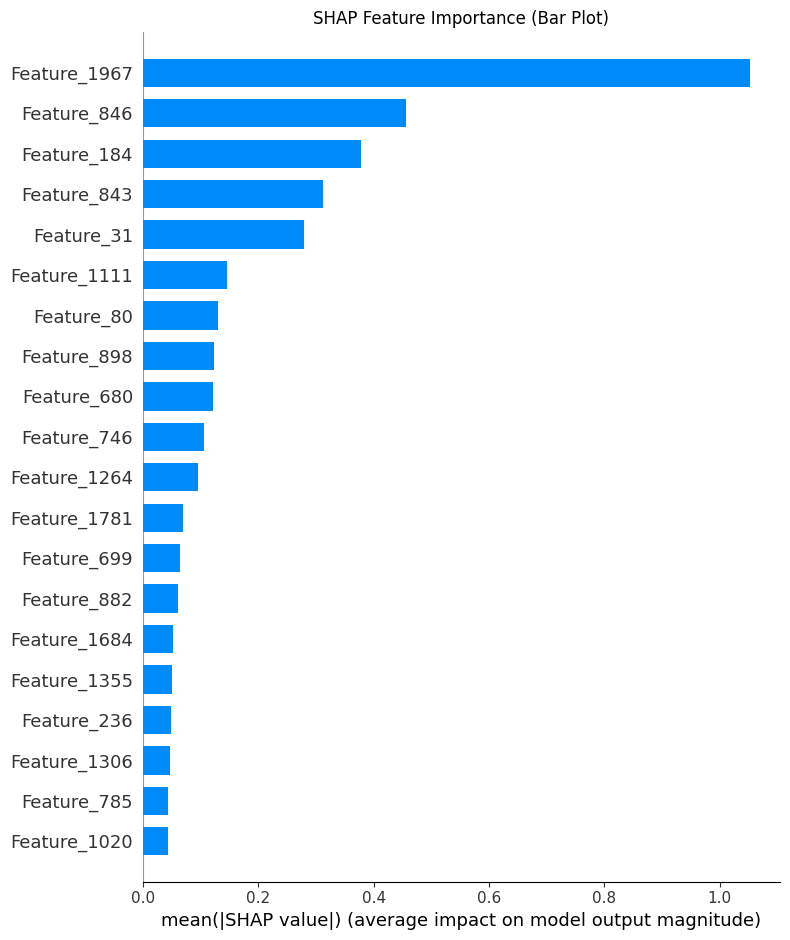

   Graphique 2: Summary plot (dot)


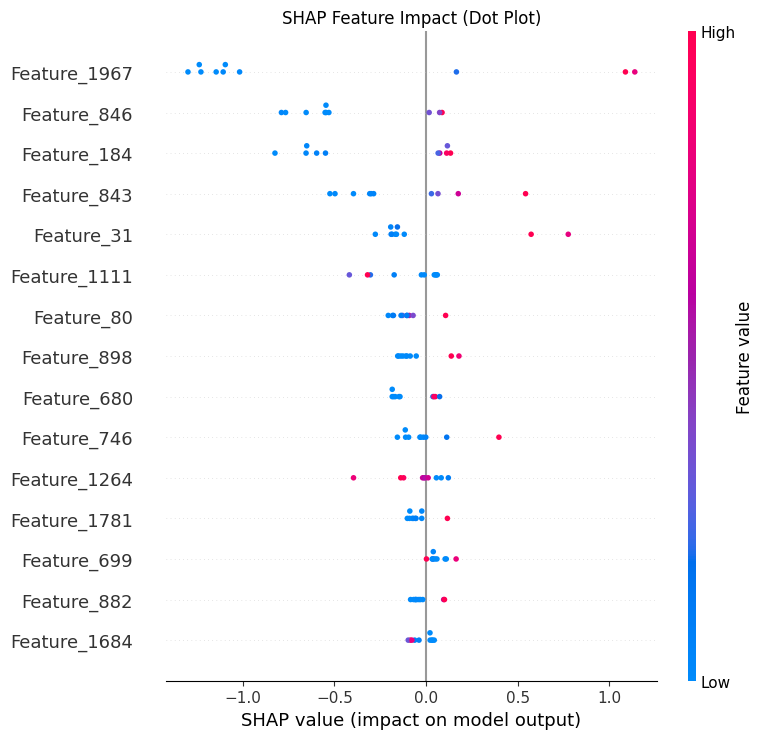

   Graphique 3: Waterfall plot


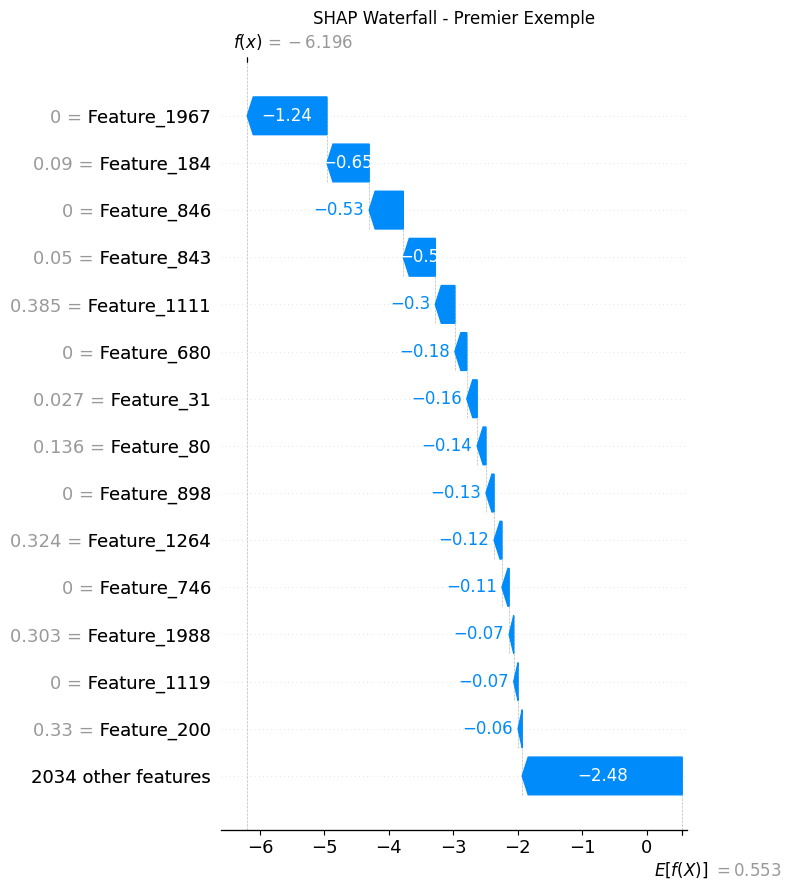

   Graphique 4: Force plot


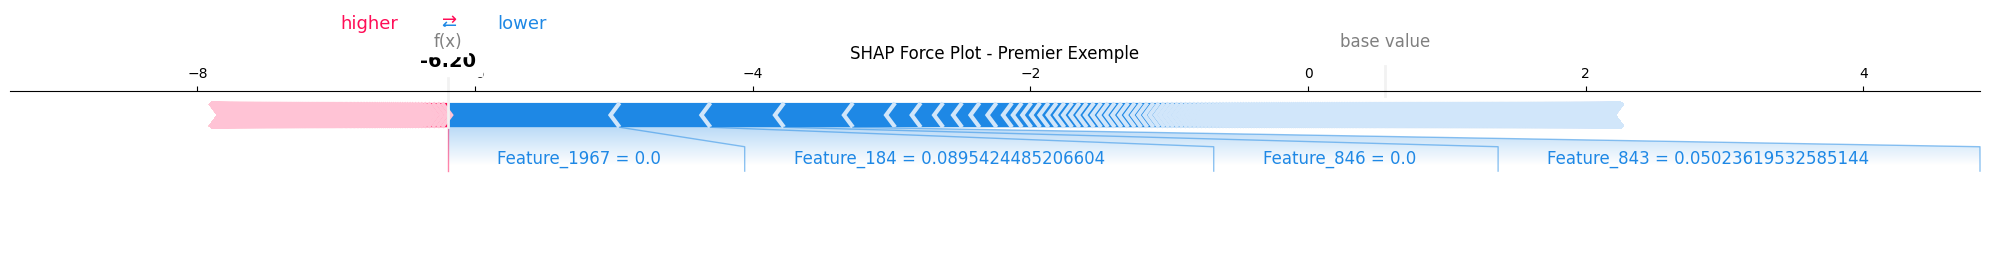

4. R√©sum√© des r√©sultats...

üìä TOP 5 FEATURES LES PLUS IMPORTANTES:
   1. Feature_1967: 1.0518
   2. Feature_846: 0.4559
   3. Feature_184: 0.3778
   4. Feature_843: 0.3122
   5. Feature_31: 0.2798

üìà STATISTIQUES SHAP:
   √âchantillons analys√©s: 10
   Features totales: 2048
   Impact moyen: -0.0016
   Impact max: 1.1385
   Impact min: -1.2985

5. Rappel des performances...

üèÜ CLASSEMENT DES MOD√àLES:
   ü•á 1. xgboost_weighted: F1=0.841, Acc=0.843
   ü•à 2. xgboost_product: F1=0.839, Acc=0.839
   ü•â 3. neural_net_weighted: F1=0.836, Acc=0.837
      4. xgboost_mean: F1=0.834, Acc=0.836
      5. xgboost_confidence_weighted: F1=0.832, Acc=0.834

‚úÖ ANALYSE SHAP TERMIN√âE!
üìÅ Graphiques g√©n√©r√©s:
   - data/reports/shap_bar_plot.png
   - data/reports/shap_dot_plot.png
   - data/reports/shap_waterfall.png
   - data/reports/shap_force_plot.png (si disponible)


In [5]:
# ==================== SHAP ULTRA-SIMPLE AVEC GRAPHIQUES NATIFS ====================
import numpy as np
import matplotlib.pyplot as plt
import shap
import traceback

print("=== SHAP SIMPLE AVEC GRAPHIQUES NATIFS ===")

try:
    # ==================== 1. PR√âPARATION ULTRA-SIMPLE ====================
    print("1. Pr√©paration des donn√©es...")
    
    # Prendre un tr√®s petit √©chantillon
    n_samples = 10
    indices = np.random.choice(len(X_image_test), min(n_samples, len(X_image_test)), replace=False)
    X_sample = X_image_test[indices]
    
    print(f"   √âchantillon: {X_sample.shape}")
    print(f"   Model XGBoost disponible: {'xgboost' in models_to_test}")
    
    # ==================== 2. EXPLICATIONS SHAP NATIVES ====================
    print("2. G√©n√©ration des explications SHAP...")
    
    # Utiliser TreeExplainer (le plus simple et rapide)
    model = models_to_test['xgboost']
    explainer = shap.TreeExplainer(model)
    
    print("   TreeExplainer cr√©√© avec succ√®s")
    
    # Calculer les valeurs SHAP
    shap_values = explainer.shap_values(X_sample)
    print(f"   SHAP values calcul√©es: {type(shap_values)}")
    
    # G√©rer le format des valeurs SHAP
    if isinstance(shap_values, list):
        print(f"   Liste de {len(shap_values)} √©l√©ments")
        shap_matrix = shap_values[0] if len(shap_values) > 0 else shap_values[0]
    elif isinstance(shap_values, np.ndarray):
        if len(shap_values.shape) == 3:
            print(f"   Format 3D: {shap_values.shape} -> prendre premi√®re classe")
            shap_matrix = shap_values[:, :, 0]
        else:
            shap_matrix = shap_values
    
    print(f"   SHAP matrix finale: {shap_matrix.shape}")
    
    # ==================== 3. GRAPHIQUES SHAP NATIFS ====================
    print("3. G√©n√©ration des graphiques SHAP...")
    
    # Cr√©er feature names simples
    feature_names = [f'Feature_{i}' for i in range(X_sample.shape[1])]
    
    # GRAPHIQUE 1: Summary Plot (Bar)
    print("   Graphique 1: Summary plot (bar)")
    plt.figure(figsize=(10, 6))
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, 
                         plot_type='bar', max_display=20, show=False)
    else:
        if len(shap_values.shape) == 3:
            shap.summary_plot(shap_values[:, :, 0], X_sample, feature_names=feature_names, 
                             plot_type='bar', max_display=20, show=False)
        else:
            shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                             plot_type='bar', max_display=20, show=False)
    
    plt.title("SHAP Feature Importance (Bar Plot)")
    plt.tight_layout()
    plt.savefig("data/reports/shap_bar_plot.png", dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # GRAPHIQUE 2: Summary Plot (Dot)
    print("   Graphique 2: Summary plot (dot)")
    plt.figure(figsize=(10, 6))
    try:
        if isinstance(shap_values, list):
            shap.summary_plot(shap_values[0], X_sample, feature_names=feature_names, 
                             max_display=15, show=False)
        else:
            if len(shap_values.shape) == 3:
                shap.summary_plot(shap_values[:, :, 0], X_sample, feature_names=feature_names, 
                                 max_display=15, show=False)
            else:
                shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                                 max_display=15, show=False)
        
        plt.title("SHAP Feature Impact (Dot Plot)")
        plt.tight_layout()
        plt.savefig("data/reports/shap_dot_plot.png", dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()
    except Exception as e:
        print(f"   Erreur dot plot: {e}")
        plt.close()
    
    # GRAPHIQUE 3: Waterfall pour le premier exemple
    print("   Graphique 3: Waterfall plot")
    try:
        plt.figure(figsize=(10, 8))
        
        if isinstance(shap_values, list):
            shap_vals_example = shap_values[0][0]
            expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
        else:
            if len(shap_values.shape) == 3:
                shap_vals_example = shap_values[0, :, 0]
                expected_value = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
            else:
                shap_vals_example = shap_values[0]
                expected_value = explainer.expected_value
        
        # Cr√©er un objet Explanation pour waterfall
        explanation = shap.Explanation(
            values=shap_vals_example,
            base_values=expected_value,
            data=X_sample[0],
            feature_names=feature_names
        )
        
        shap.waterfall_plot(explanation, max_display=15, show=False)
        plt.title("SHAP Waterfall - Premier Exemple")
        plt.tight_layout()
        plt.savefig("data/reports/shap_waterfall.png", dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"   Erreur waterfall: {e}")
        plt.close()
    
    # GRAPHIQUE 4: Force Plot (si possible)
    print("   Graphique 4: Force plot")
    try:
        if isinstance(shap_values, list):
            shap_vals_force = shap_values[0][0]
            expected_value_force = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
        else:
            if len(shap_values.shape) == 3:
                shap_vals_force = shap_values[0, :, 0]
                expected_value_force = explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value
            else:
                shap_vals_force = shap_values[0]
                expected_value_force = explainer.expected_value
        
        # Force plot en matplotlib
        shap.force_plot(
            expected_value_force, 
            shap_vals_force, 
            X_sample[0], 
            feature_names=feature_names,
            matplotlib=True,
            show=False
        )
        plt.title("SHAP Force Plot - Premier Exemple")
        plt.tight_layout()
        plt.savefig("data/reports/shap_force_plot.png", dpi=200, bbox_inches='tight')
        plt.show()
        plt.close()
        
    except Exception as e:
        print(f"   Force plot non disponible: {e}")
    
    # ==================== 4. R√âSUM√â SIMPLE ====================
    print("4. R√©sum√© des r√©sultats...")
    
    # Calculer importance moyenne
    mean_importance = np.mean(np.abs(shap_matrix), axis=0)
    top_5_indices = np.argsort(mean_importance)[-5:]
    
    print(f"\nüìä TOP 5 FEATURES LES PLUS IMPORTANTES:")
    for i, idx in enumerate(reversed(top_5_indices), 1):
        print(f"   {i}. Feature_{idx}: {mean_importance[idx]:.4f}")
    
    print(f"\nüìà STATISTIQUES SHAP:")
    print(f"   √âchantillons analys√©s: {shap_matrix.shape[0]}")
    print(f"   Features totales: {shap_matrix.shape[1]}")
    print(f"   Impact moyen: {np.mean(shap_matrix):.4f}")
    print(f"   Impact max: {np.max(shap_matrix):.4f}")
    print(f"   Impact min: {np.min(shap_matrix):.4f}")
    
    # ==================== 5. COMPARAISON PERFORMANCES ====================
    print("\n5. Rappel des performances...")
    
    if 'valid_results' in globals():
        print(f"\nüèÜ CLASSEMENT DES MOD√àLES:")
        
        # Trier par F1-score
        sorted_results = sorted(valid_results.items(), 
                               key=lambda x: x[1].get('weighted_f1', 0), 
                               reverse=True)
        
        for i, (model_name, metrics) in enumerate(sorted_results[:5], 1):
            medal = "ü•á" if i == 1 else "ü•à" if i == 2 else "ü•â" if i == 3 else "  "
            f1_score = metrics.get('weighted_f1', 0)
            accuracy = metrics.get('accuracy', 0)
            print(f"   {medal} {i}. {model_name}: F1={f1_score:.3f}, Acc={accuracy:.3f}")
    
    print("\n‚úÖ ANALYSE SHAP TERMIN√âE!")
    print("üìÅ Graphiques g√©n√©r√©s:")
    print("   - data/reports/shap_bar_plot.png")
    print("   - data/reports/shap_dot_plot.png") 
    print("   - data/reports/shap_waterfall.png")
    print("   - data/reports/shap_force_plot.png (si disponible)")
    
except Exception as e:
    print(f"‚ùå Erreur g√©n√©rale: {e}")
    print(f"üí° D√©tails: {traceback.format_exc()}")
    
    # Fallback ultra-simple
    print("\nüîÑ Tentative de fallback ultra-simple...")
    try:
        # Juste afficher l'importance native du mod√®le
        if 'models_to_test' in globals() and 'xgboost' in models_to_test:
            model = models_to_test['xgboost']
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                
                plt.figure(figsize=(10, 6))
                top_n = min(20, len(importances))
                top_indices = np.argsort(importances)[-top_n:]
                
                plt.barh(range(top_n), importances[top_indices])
                plt.yticks(range(top_n), [f'Feature_{i}' for i in top_indices])
                plt.xlabel('Importance')
                plt.title('XGBoost Native Feature Importance')
                plt.tight_layout()
                plt.savefig("data/reports/fallback_importance.png", dpi=200, bbox_inches='tight')
                plt.show()
                plt.close()
                
                print("‚úÖ Graphique de fallback g√©n√©r√©: fallback_importance.png")
            else:
                print("‚ùå Pas de feature_importances_ disponible")
        else:
            print("‚ùå Mod√®le XGBoost non trouv√©")
    except Exception as e2:
        print(f"‚ùå Fallback √©chou√© aussi: {e2}")